**Imports and includes**

In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys
import glob

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment analysis function provided by Upasana**

In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Create list of all Baseline Users**

In [5]:
# all_user_lists=[
#     "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/DidNotMentionBack_Users/Filtered_EnglishUsers_DidNotMentionedBackUsers_FINAL.csv",
#     "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/MentionedBack_Users/Filtered_EnglishUsers_MentionedBackUsers_FINAL.csv",
#     '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_DidnotMentionBackUsers.csv',
#     '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_MentionBackedUsers.csv']

# UserList = []
# userPathDict = {}
# for i in range(4):  
#     df = pd.read_csv(all_user_lists[i])
#     tempUserList = list(df['Users'])
#     for j in range(len(tempUserList)):
#         UserList.append(tempUserList[j])
#         if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
#         elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
#         elif (i == 2) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
#         elif (i == 3) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
    

In [6]:
df = pd.read_csv('../BeforeAndAfterAnalysis/Filtered_EnglishUsers_MentionBackedUsers.csv')
UserList = list(df['Users'])

In [7]:
print("Number of possibly affected users: " + str(len(UserList)))

Number of possibly affected users: 623


In [8]:
# with open('pau_all.txt', 'w') as filehandle:
#     for listitem in UserList:
#         filehandle.write('%s\n' % listitem)

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**

In [9]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [10]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Calculate monthy values for each user (over the 96 months from Jan 2009 to December 2016)**

In [11]:
timelineDict = {}

In [12]:
firstTweetIndexDict = {}

In [13]:
timelineDF = pd.DataFrame(columns=['username','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

In [14]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(100):
    try:
        #read in, reverse order (so oldest is first), reset index
        temp_user_db = pd.read_csv('/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'+UserList[i]+'.csv', header=None, low_memory=False)
        temp_user_db = temp_user_db.iloc[::-1]
        temp_user_db.reset_index(drop=True, inplace=True)

        #create lists for each metric
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        positive_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        negative_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]

        #iterate through user tweets
        first = 1
        for j in range(len(temp_user_db)):

            #step one is assigning an index for the tweet, based on date, or disregarding
            found = 0
            tweetdate = dt.strptime(temp_user_db[3][j], "%Y-%m-%d")
            for k in range(2009,2017):
                temp_year = k
                date_start = dt(temp_year,1,1)
                date_end = dt(temp_year,12,31)
                if tweetdate < date_start:
                    continue;
                elif tweetdate <= date_end:
                    for m in range(2,14):
                        if m == 13: #month must be December by process of elimination
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;
                        next_month_start = dt(temp_year,m,1)
                        if tweetdate < next_month_start:
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;

            #tweet occurred within the period 2009-2016 and was assigned an valid index
            if found == 1:
                if first:
                    firstTweetIndexDict[UserList[i]] = use_index
                    first = 0

                tweet_count[use_index] +=1

                tweet_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                sentiment_scores[use_index].append(tweet_sent)

                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))

                if trump_flag: trump_count[use_index] += 1
                if clinton_flag: clinton_count[use_index] += 1

                if trump_flag and not clinton_flag: trump_sent[use_index].append(tweet_sent)
                if clinton_flag and not trump_flag: clinton_sent[use_index].append(tweet_sent)

                if tweet_sent > 0: positive_sent[use_index].append(tweet_sent)
                if tweet_sent < 0: negative_sent[use_index].append(tweet_sent)

        timelineDict[UserList[i]] = [tweet_count, sentiment_scores, trump_count, clinton_count, 
                                     trump_sent, clinton_sent, positive_sent, negative_sent]

        print(str(i) + " / " + size)

    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))

        

0 / 623
1 / 623
2 / 623
3 / 623
4 / 623
5 / 623
6 / 623
7 / 623
8 / 623
9 / 623
10 / 623
11 / 623
12 / 623
13 / 623
14 / 623
15 / 623
16 / 623
17 / 623
18 / 623
19 / 623
20 / 623
21 / 623
22 / 623
23 / 623
24 / 623
25 / 623
26 / 623
27 / 623
28 / 623
29 / 623
30 / 623
31 / 623
32 / 623
33 / 623
34 / 623
35 / 623
36 / 623
37 / 623
38 / 623
39 / 623
40 / 623
41 / 623
42 / 623
43 / 623
44 / 623
45 / 623
46 / 623
47 / 623
48 / 623
49 / 623
50 / 623
51 / 623
52 / 623
53 / 623
54 / 623
55 / 623
56 / 623
57 / 623
58 / 623
59 / 623
60 / 623
61 / 623
62 / 623
63 / 623
64 / 623
65 / 623
66 / 623
67 / 623
68 / 623
69 / 623
70 / 623
71 / 623
72 / 623
73 / 623
74 / 623
75 / 623
76 / 623
77 / 623
78 / 623
79 / 623
80 / 623
81 / 623
82 / 623
83 / 623
84 / 623
85 / 623
86 / 623
87 / 623
88 / 623
89 / 623
90 / 623
109 / 623
110 / 623
111 / 623
112 / 623
113 / 623
114 / 623
115 / 623
116 / 623
117 / 623
118 / 623
119 / 623
120 / 623
121 / 623
122 / 623
123 / 623
124 / 623
125 / 623
126 / 623
127 / 623
1

In [15]:
len(firstTweetIndexDict)

608

In [16]:
for i in range(len(timelineDF)):
    try:
        test = firstTweetIndexDict[timelineDF['username'][i]]
    except:
        print(timelineDF['username'][i] + ' failed [' +str(i)+']' )

In [17]:
timelineDF = pd.DataFrame.from_dict(timelineDict, orient='index',columns=['tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

timelineDF.index.name = 'username'
timelineDF.reset_index(inplace=True)


In [18]:
len(timelineDF)

623

In [19]:
tweet_countDict = {}
sentiment_scoresDict = {}
trump_countDict = {}
clinton_countDict = {}
trump_sentDict = {}
clinton_sentDict = {}
positive_sentDict = {}
negative_sentDict = {} 

In [20]:
size = str(len(timelineDF))
for i in range(len(timelineDF)):
    try:
        start_index = firstTweetIndexDict[timelineDF['username'][i]]

        tweet_count = []
        sentiment_scores = []
        trump_count = []
        clinton_count = []
        trump_sent = []
        clinton_sent = []
        positive_sent = []
        negative_sent = [] 

        for j in range(0,96):
            if j >= start_index:
                tweet_count.append(timelineDF['tweet_count'][i][j])
                trump_count.append(timelineDF['trump_count'][i][j])
                clinton_count.append(timelineDF['clinton_count'][i][j])

                if(len(timelineDF['sentiment_scores'][i][j]) > 0):
                    sentiment_scores.append(statistics.mean(timelineDF['sentiment_scores'][i][j]))
                else:
                    sentiment_scores.append(np.nan)

                if(len(timelineDF['trump_sent'][i][j]) > 0):
                    trump_sent.append(statistics.mean(timelineDF['trump_sent'][i][j]))
                else:
                    trump_sent.append(np.nan)

                if(len(timelineDF['clinton_sent'][i][j]) > 0):
                    clinton_sent.append(statistics.mean(timelineDF['clinton_sent'][i][j]))
                else:
                    clinton_sent.append(np.nan)

                if(len(timelineDF['positive_sent'][i][j]) > 0):
                    positive_sent.append(statistics.mean(timelineDF['positive_sent'][i][j]))
                else:
                    positive_sent.append(np.nan)

                if(len(timelineDF['negative_sent'][i][j]) > 0):
                    negative_sent.append(statistics.mean(timelineDF['negative_sent'][i][j]))
                else:
                    negative_sent.append(np.nan)

            else:
                tweet_count.append(np.nan)
                trump_count.append(np.nan)
                clinton_count.append(np.nan)
                sentiment_scores.append(np.nan)
                trump_sent.append(np.nan)
                clinton_sent.append(np.nan)
                positive_sent.append(np.nan)
                negative_sent.append(np.nan)

        tweet_countDict[timelineDF['username'][i]] = tweet_count
        sentiment_scoresDict[timelineDF['username'][i]] = sentiment_scores
        trump_countDict[timelineDF['username'][i]] = trump_count
        clinton_countDict[timelineDF['username'][i]] = clinton_count
        trump_sentDict[timelineDF['username'][i]] = trump_sent
        clinton_sentDict[timelineDF['username'][i]] = clinton_sent
        positive_sentDict[timelineDF['username'][i]] = positive_sent
        negative_sentDict[timelineDF['username'][i]] =  negative_sent 

        print(str(i) + " / " + size)
        
    except Exception as e: 
        print(str(timelineDF['username'][i]) + " failed - " + str(e))

0 / 623
1 / 623
2 / 623
3 / 623
4 / 623
5 / 623
6 / 623
7 / 623
8 / 623
9 / 623
10 / 623
11 / 623
12 / 623
13 / 623
14 / 623
15 / 623
16 / 623
17 / 623
18 / 623
Amber_Aquarius failed - 'Amber_Aquarius'
20 / 623
AezhinAhrr failed - 'AezhinAhrr'
22 / 623
23 / 623
24 / 623
25 / 623
26 / 623
27 / 623
28 / 623
29 / 623
30 / 623
31 / 623
32 / 623
33 / 623
34 / 623
DonnieCarez failed - 'DonnieCarez'
36 / 623
37 / 623
38 / 623
39 / 623
40 / 623
41 / 623
42 / 623
43 / 623
44 / 623
45 / 623
46 / 623
47 / 623
48 / 623
terileemcclain failed - 'terileemcclain'
50 / 623
51 / 623
52 / 623
53 / 623
54 / 623
55 / 623
56 / 623
57 / 623
58 / 623
59 / 623
60 / 623
61 / 623
62 / 623
63 / 623
64 / 623
65 / 623
66 / 623
67 / 623
68 / 623
69 / 623
70 / 623
71 / 623
72 / 623
73 / 623
74 / 623
75 / 623
Tonyg04456745 failed - 'Tonyg04456745'
77 / 623
78 / 623
79 / 623
BeezakaMrB failed - 'BeezakaMrB'
81 / 623
82 / 623
83 / 623
84 / 623
85 / 623
86 / 623
87 / 623
dynamex failed - 'dynamex'
89 / 623
90 / 623
91 / 

In [21]:
tweet_countDF = pd.DataFrame.from_dict(tweet_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
tweet_countDF.index.name = 'username'
tweet_countDF.reset_index(inplace=True)
tweet_countDF = tweet_countDF.drop(columns=['username'])

trump_countDF = pd.DataFrame.from_dict(trump_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_countDF.index.name = 'username'
trump_countDF.reset_index(inplace=True)
trump_countDF = trump_countDF.drop(columns=['username'])

clinton_countDF = pd.DataFrame.from_dict(clinton_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_countDF.index.name = 'username'
clinton_countDF.reset_index(inplace=True)
clinton_countDF = clinton_countDF.drop(columns=['username'])

sentiment_scoresDF = pd.DataFrame.from_dict(sentiment_scoresDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
sentiment_scoresDF.index.name = 'username'
sentiment_scoresDF.reset_index(inplace=True)
sentiment_scoresDF = sentiment_scoresDF.drop(columns=['username'])

trump_sentDF = pd.DataFrame.from_dict(trump_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_sentDF.index.name = 'username'
trump_sentDF.reset_index(inplace=True)
trump_sentDF = trump_sentDF.drop(columns=['username'])

clinton_sentDF = pd.DataFrame.from_dict(clinton_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_sentDF.index.name = 'username'
clinton_sentDF.reset_index(inplace=True)
clinton_sentDF = clinton_sentDF.drop(columns=['username'])

positive_sentDF = pd.DataFrame.from_dict(positive_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
positive_sentDF.index.name = 'username'
positive_sentDF.reset_index(inplace=True)
positive_sentDF = positive_sentDF.drop(columns=['username'])

negative_sentDF = pd.DataFrame.from_dict(negative_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
negative_sentDF.index.name = 'username'
negative_sentDF.reset_index(inplace=True)
negative_sentDF = negative_sentDF.drop(columns=['username'])

In [22]:
timelineDF.to_pickle("./GEN_RES_TIMELINE.pkl")

In [23]:
tweet_countDF.to_pickle("./GEN_RES_tweet_countDF_100420.pkl")
trump_countDF.to_pickle("./GEN_RES_trump_countDF_100420.pkl")
clinton_countDF.to_pickle("./GEN_RES_clinton_countDF_100420.pkl")
sentiment_scoresDF.to_pickle("./GEN_RES_sentiment_scoresDF_100420.pkl")
trump_sentDF.to_pickle("./GEN_RES_trump_sentDF_100420.pkl")
clinton_sentDF.to_pickle("./GEN_RES_clinton_sentDF_100420.pkl")
positive_sentDF.to_pickle("./GEN_RES_positive_sentDF_100420.pkl")
negative_sentDF.to_pickle("./GEN_RES_negative_sentDF_100420.pkl")


In [24]:
# unpickled_df = pd.read_pickle("./negative_sentDF_090320.pkl")

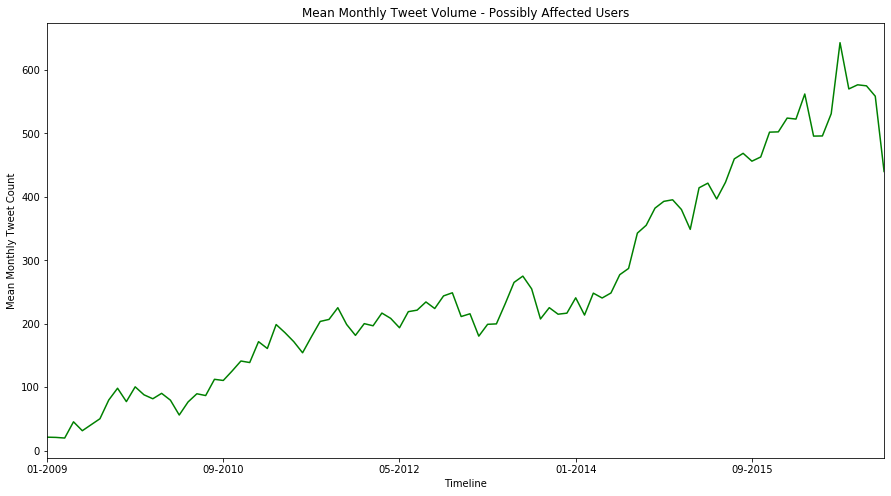

In [25]:
plt.figure()
tweet_countDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Mean Monthly Tweet Volume - Possibly Affected Users')
# plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Tweet Count')
plt.xlabel('Timeline')
plt.savefig('PAU_graphics/GEN_RES_tweetcount.png')
plt.show()

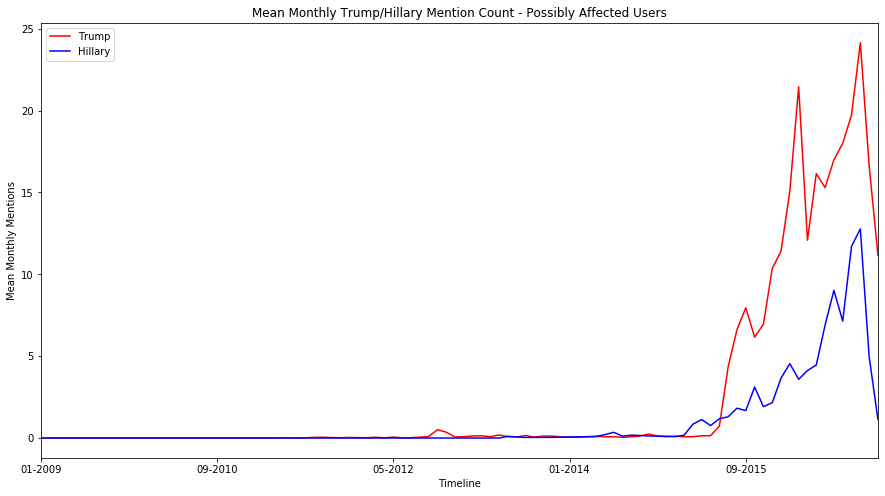

In [26]:
plt.figure()
trump_countDF.mean().plot(kind='line', color='red', figsize=(15,8),title='Mean Monthly Trump/Hillary Mention Count - Possibly Affected Users')
clinton_countDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Mentions')
plt.savefig('PAU_graphics/GEN_RES_mentions.png')
plt.xlabel('Timeline')
plt.show()

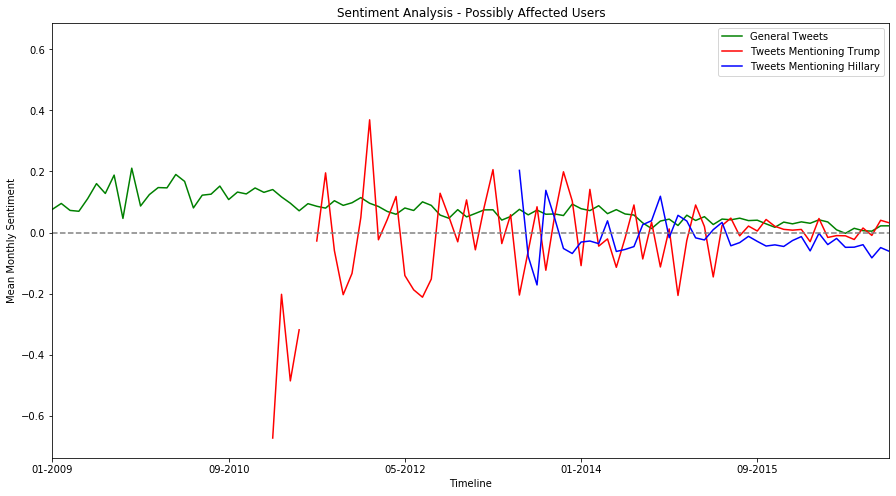

In [27]:
plt.figure()
sentiment_scoresDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Sentiment Analysis - Possibly Affected Users')
trump_sentDF.mean().plot(kind='line', color='red', figsize=(15,8))
clinton_sentDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('General Tweets','Tweets Mentioning Trump','Tweets Mentioning Hillary'))
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel('Mean Monthly Sentiment')
plt.savefig('PAU_graphics/GEN_RES_sentiment.png')
plt.xlabel('Timeline')
plt.show()